In [1]:
import os
import cv2

# Define the new dataset path
dataset_path = "maizeDataset"

# Define class names
categories = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"
] 

# ========================= Make sure images are being found in dir =========================

# Count images per class
class_counts = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    class_counts[category] = len(os.listdir(category_path))

# Print class distributions
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Get image size dynamically from first image
for category in categories:
    category_path = os.path.join(dataset_path, category)
    first_image = next(iter(os.listdir(category_path)), None)

    if first_image:
        img_path = os.path.join(category_path, first_image)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, channels = img.shape
            print(f"Image size: {width}x{height}, Channels: {channels}")
            break 
IMG_SIZE = (width, height)
print(f"Using Image Size: {IMG_SIZE}") 


Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___healthy: 1162 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Image size: 256x256, Channels: 3
Using Image Size: (256, 256)


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32

# Data augmentation and rescaling + # 80% training, 20% validation
datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2 
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True, 
    classes= ["Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"]
)
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=True, 
    classes= ["Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"]
)
print("Class indices:", train_generator.class_indices)


2025-03-13 19:28:30.135139: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 3083 images belonging to 4 classes.
Found 769 images belonging to 4 classes.
Class indices: {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0, 'Corn_(maize)___Common_rust_': 1, 'Corn_(maize)___healthy': 2, 'Corn_(maize)___Northern_Leaf_Blight': 3}


In [3]:
from sklearn.utils import class_weight
import numpy as np

# Weight the classes to counter act an unbalanced class size

labels = []
for i, category in enumerate(categories):
    labels.extend([i] * class_counts[category])

class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: np.float64(1.8771929824561404), 1: np.float64(0.8078859060402684), 2: np.float64(0.8287435456110155), 3: np.float64(0.9776649746192894)}


In [4]:
from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(4, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()


/home/larizmen/micromamba/envs/2strawberry_detection/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-13 19:28:37.702389: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-03-13 19:28:37.718774: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-03-13 19:28:37.726430: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import time 
start_time = time.time()   

# Run Training

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15, 
    class_weight=class_weights_dict 
) 

end_time = time.time() 
total_time = end_time - start_time 
print(f"\nTotal Training time: {total_time:.2f} seconds. {total_time/60:.2f} minutes")


Epoch 1/15


/home/larizmen/micromamba/envs/2strawberry_detection/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-03-13 19:28:41.799283: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2025-03-13 19:28:42.463006: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


97/97 ━━━━━━━━━━━━━━━━━━━━ 98s 989ms/step - accuracy: 0.5495 - loss: 1.4694 - val_accuracy: 0.8739 - val_loss: 0.2983
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 93s 955ms/step - accuracy: 0.8360 - loss: 0.4298 - val_accuracy: 0.8843 - val_loss: 0.2913
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8496 - loss: 0.3721 - val_accuracy: 0.8947 - val_loss: 0.2355
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8772 - loss: 0.3475 - val_accuracy: 0.9272 - val_loss: 0.1699
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9122 - loss: 0.2652 - val_accuracy: 0.9116 - val_loss: 0.1862
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9103 - loss: 0.3187 - val_accuracy: 0.9285 - val_loss: 0.1727
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 86s 880ms/step - accuracy: 0.9079 - loss: 0.2801 - val_accuracy: 0.9337 - val_loss: 0.1598
Epoch 8/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 91s 937ms/step - accuracy: 0.9326 - loss: 0.2057 - val_accuracy: 0.9090 - val_

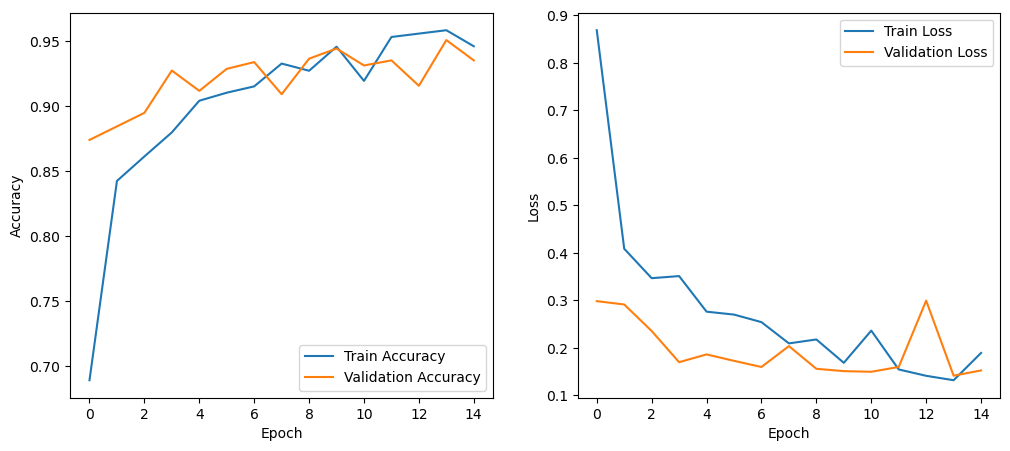

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [7]:
import random
import os 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image 

base_dir = "maizeDataset"

categories = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"
]

def get_random_image():
    """Selects a random image from one of the four datasets and returns its full path."""
     
    category = random.choice(categories)  
    
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    if not images:
        return None 
    random_image = random.choice(images)
    return os.path.join(category_path, random_image), category 

# Predict and image 
def predict_image(img_path, category):
    img_name = os.path.basename(img_path)  

    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  

    # Make prediction
    prediction = model.predict(img_array)[0] 

    class_index = np.argmax(prediction) 
    class_label = list(train_generator.class_indices.keys())[class_index]

    # Print results
    print(f"Image: {img_name}")
    print(f" Confidence: {prediction[class_index]:.4f} \n Predicted Class: {class_label} \n Actual Class   : {category}")

    # Show the image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"{img_name}\n{class_label} ({prediction[class_index]:.4f})")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Image: RS_Rust 1623.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


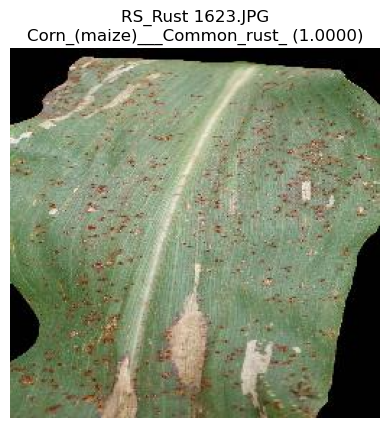

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: 3e1226c4-baf1-46fa-8253-e777ca911e2f___R.S_HL 8345 copy.jpg
 Confidence: 0.9997 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


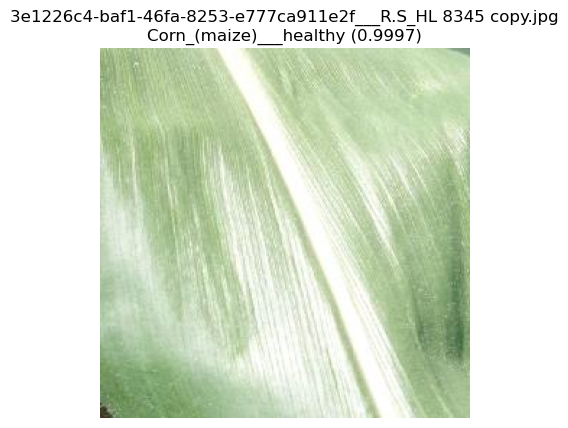

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: 72bbfeba-b355-47d3-aa0e-3c9a148575aa___RS_NLB 3912.JPG
 Confidence: 0.7773 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


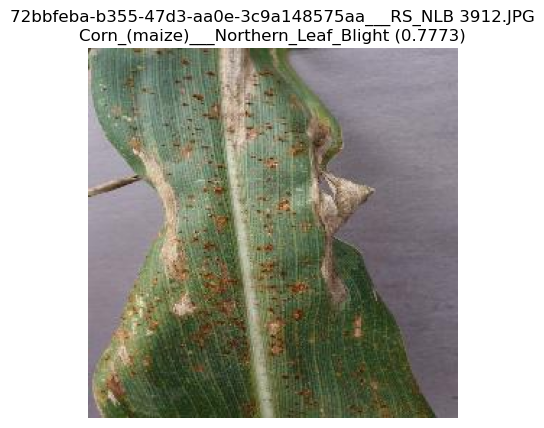

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: RS_Rust 1667.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


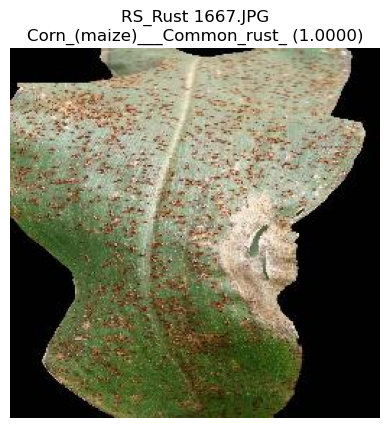

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Image: 6089948d-346f-4745-af12-4355a7ef3dea___RS_NLB 3800.JPG
 Confidence: 0.8057 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


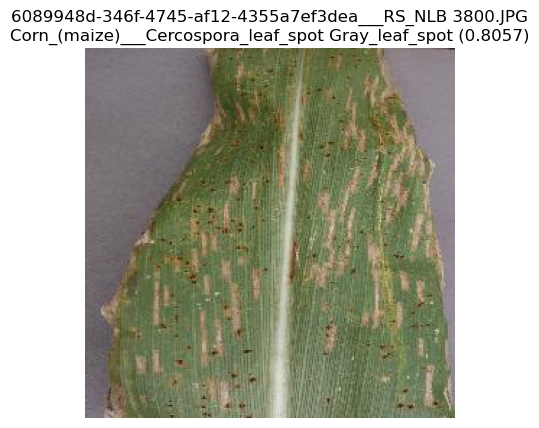

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: eb3708a1-b2b4-4e03-b8ae-59c14ef89e67___RS_NLB 3818 copy.jpg
 Confidence: 0.9999 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


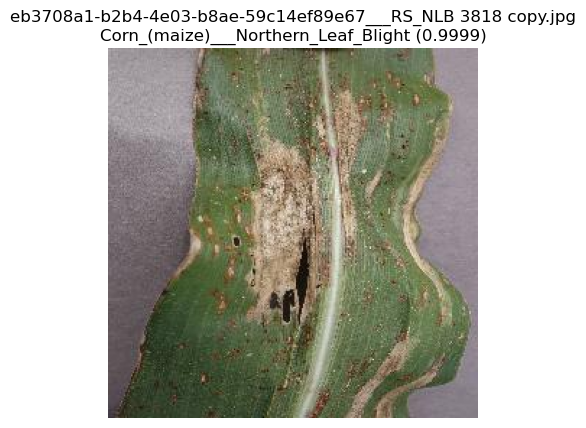

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: f6244bb0-89ef-4256-bc25-701f6a66f1fa___R.S_HL 5508 copy 2.jpg
 Confidence: 0.9982 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


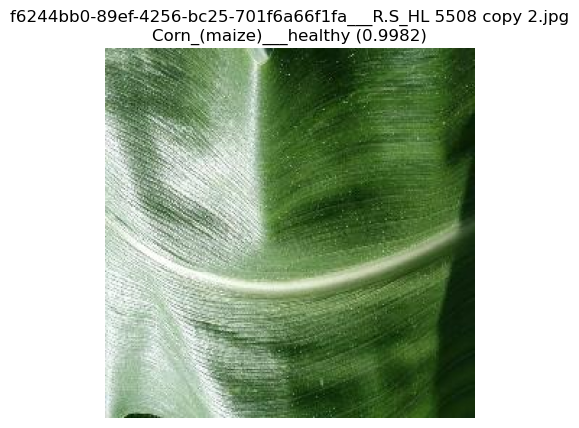

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: RS_Rust 2399.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


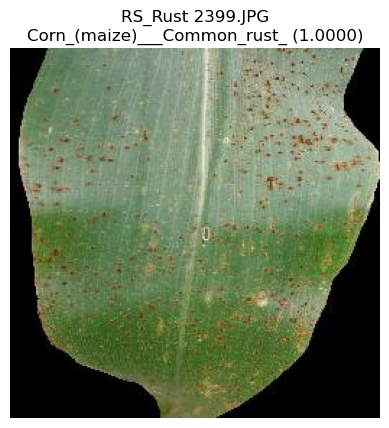

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: RS_Rust 2458.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


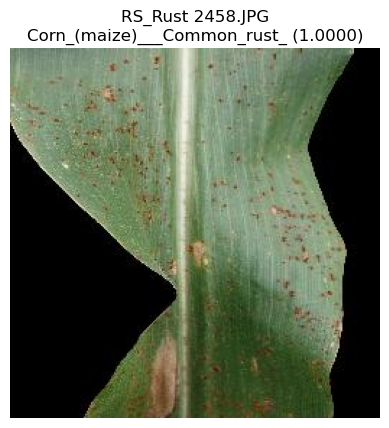

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Image: a312677c-a2d5-4aa0-bb76-0f1af43fb747___RS_GLSp 4395.JPG
 Confidence: 0.9813 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


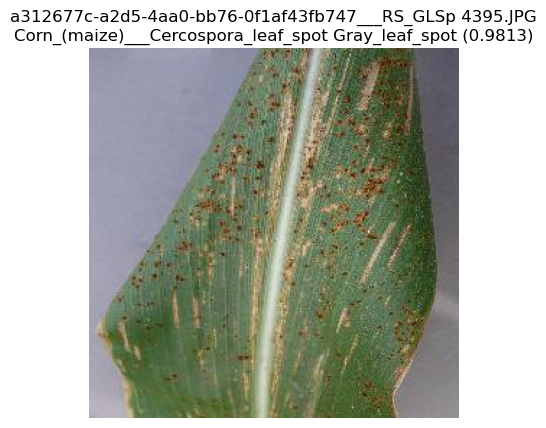

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Image: 0657e6c0-5a6d-4ef3-807a-4e31e57fb683___RS_GLSp 7344 copy.jpg
 Confidence: 0.6904 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


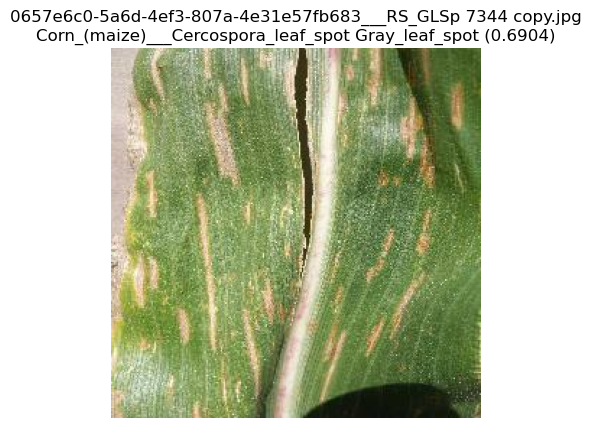

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Image: e55e0dbd-5b63-463f-8556-ae18f1e50f7e___R.S_HL 8222 copy 2.jpg
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


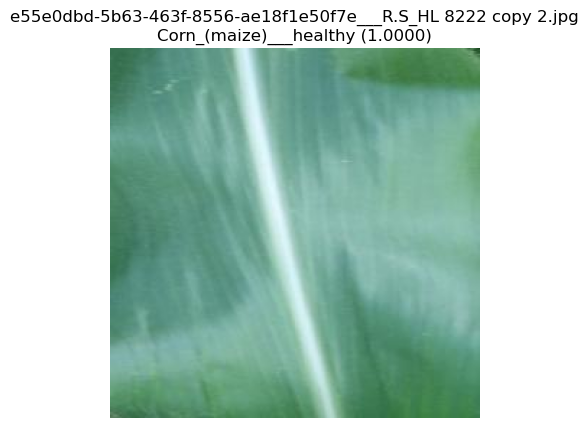

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Image: RS_Rust 1665.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


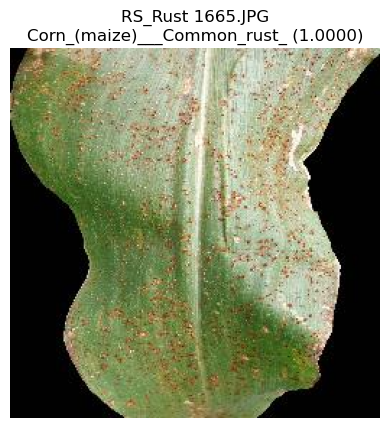

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image: RS_Rust 1613.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


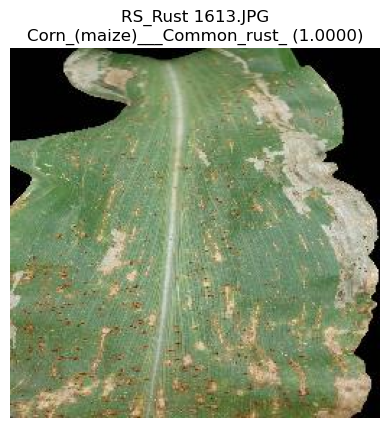

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Image: 15d188d6-bade-4281-931a-82264fdae6a4___RS_GLSp 4450.JPG
 Confidence: 0.6030 
 Predicted Class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 
 Actual Class   : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


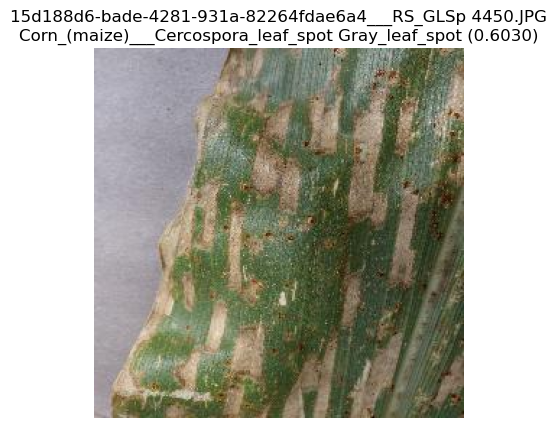

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image: 028a7e62-b520-42fe-8607-ee4d4bc6764d___RS_NLB 3844.JPG
 Confidence: 0.7910 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


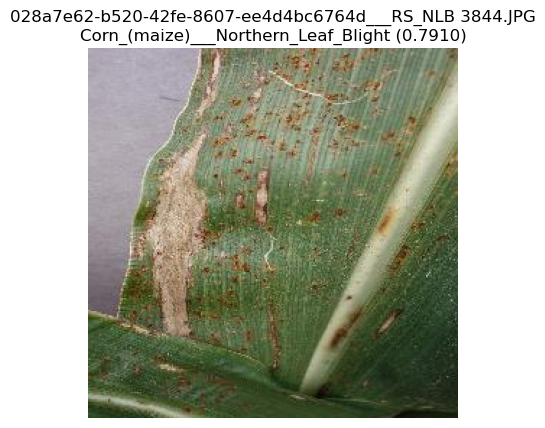

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Image: 011b766d-7744-420d-a1a1-57bdff9b4ddd___RS_NLB 4128.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


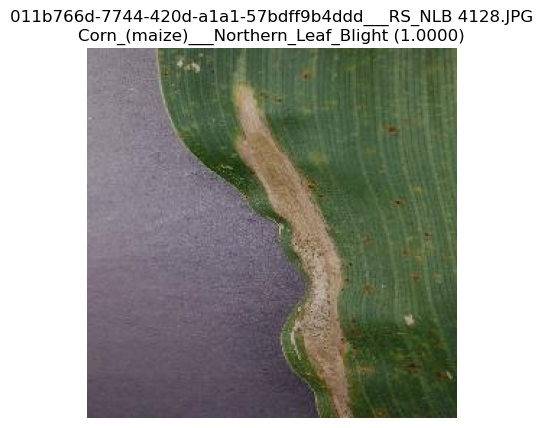

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Image: 624c0cfa-3729-4f6c-9236-1c3a4ee66431___R.S_HL 8214 copy.jpg
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___healthy 
 Actual Class   : Corn_(maize)___healthy


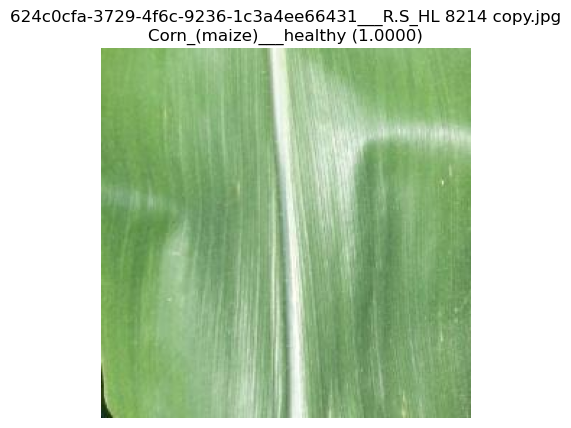

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image: 0118e276-ee7b-4fed-961d-057590ae9f7f___RS_NLB 4666 copy 2.jpg
 Confidence: 0.9110 
 Predicted Class: Corn_(maize)___Northern_Leaf_Blight 
 Actual Class   : Corn_(maize)___Northern_Leaf_Blight


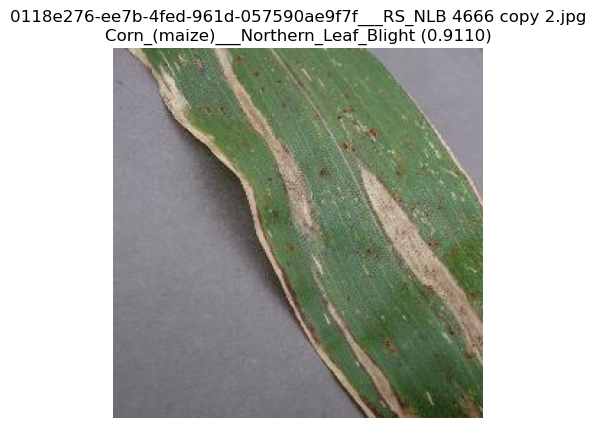

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Image: RS_Rust 1861.JPG
 Confidence: 1.0000 
 Predicted Class: Corn_(maize)___Common_rust_ 
 Actual Class   : Corn_(maize)___Common_rust_


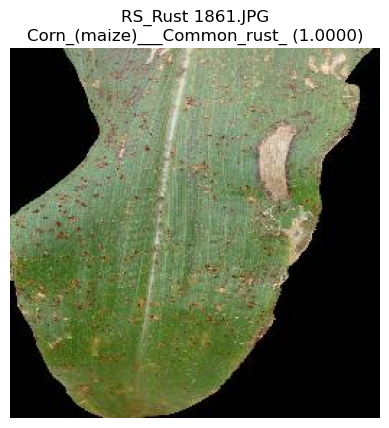

In [8]:
# GEt random images and show their predictions
tests = 20
for i in range(tests):   
    rand_img, cat = get_random_image()
    predict_image(rand_img, cat)